In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45,5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777,-4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

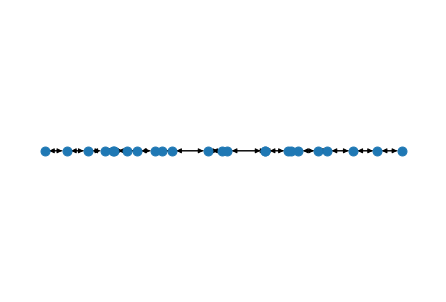

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 7 on the graph for energy use simulation

In [5]:
path_down_7_Regensburg2Budapest = nx.dijkstra_path(FG, nodes[0].name, nodes[23].name)

### Create vessel sailing on path 7 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path 7 include 17 vessel types sailing downstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_down_ballast = {
    "env": None,
    "name": 'MCV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_ballast = {
    "env": None,
    "name": 'MCV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_down_ballast = {
    "env": None,
    "name": 'MCV105_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_down_ballast = {
    "env": None,
    "name": 'MCV95_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_ballast = {
    "env": None,
    "name": 'MCV85_9_5_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_ballast = {
    "env": None,
    "name": 'MCV85_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_ballast = {
    "env": None,
    "name": 'MCV80_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_down_ballast = {
    "env": None,
    "name": 'MTV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_ballast = {
    "env": None,
    "name": 'MTV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_down_ballast = {
    "env": None,
    "name": 'MTV85_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_ballast = {
    "env": None,
    "name": 'PUSH23_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_ballast = {
    "env": None,
    "name": 'PUSH23_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_ballast = {
    "env": None,
    "name": 'PUSH35_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_ballast = {
    "env": None,
    "name": 'PUSH35_4B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 133.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_ballast = {
    "env": None,
    "name": 'PUSH57_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 133.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_40ft_containers']
    # df_energy = df[selected]
    # df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selected = ['distance','total_H2_500bar_PEMFC_mass','total_H2_500bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km']= df_energy['distance']/1000
    df_energy['distance_km_cum']=df_energy['distance_km'].cumsum()
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    df_energy['total_trips_H2_500bar_PEMFC_mass_ton'] = df_energy['total_H2_500bar_PEMFC_mass']*nr_trips/1000000
    df_energy['total_trips_H2_500bar_PEMFC_40ft_containers'] = df_energy['total_H2_500bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_500bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_500bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selection= ['distance_km', 'distance_km_cum','total_trips_H2_500bar_PEMFC_mass_ton','total_trips_H2_500bar_PEMFC_40ft_containers']
    df_energy = df_energy[selection]
    
    return df_energy

In [43]:
energy_MCV135_down_loaded_MHWL_path = get_energy(1,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV135_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.071083,0.072793
1,44.0,89.0,0.059942,0.061385
2,34.0,123.0,0.043118,0.044155
3,17.0,140.0,0.024664,0.025258
4,2.0,142.0,0.002902,0.002971
5,28.0,170.0,0.034444,0.035273
6,19.0,189.0,0.021539,0.022058
7,37.0,226.0,0.061950,0.063441
8,15.0,241.0,0.035418,0.036271
9,20.0,261.0,0.027116,0.027769


In [44]:
energy_MCV135_down_ballast_MHWL_path = get_energy(2,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_ballast)
# pd.options.display.max_columns = None
energy_MCV135_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.189377,0.193935
1,44.0,89.0,0.140133,0.143506
2,34.0,123.0,0.085254,0.087305
3,17.0,140.0,0.064029,0.065570
4,2.0,142.0,0.007533,0.007714
5,28.0,170.0,0.087946,0.090062
6,19.0,189.0,0.052593,0.053858
7,37.0,226.0,0.171218,0.175339
8,15.0,241.0,0.097900,0.100256
9,20.0,261.0,0.070334,0.072027


In [45]:
energy_MCV110_down_loaded_MHWL_path = get_energy(9,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.528173,0.540883
1,44.0,89.0,0.445812,0.456541
2,34.0,123.0,0.227180,0.232648
3,17.0,140.0,0.181833,0.186209
4,2.0,142.0,0.021392,0.021907
5,28.0,170.0,0.255633,0.261785
6,19.0,189.0,0.161063,0.164939
7,37.0,226.0,0.462812,0.473950
8,15.0,241.0,0.263998,0.270352
9,20.0,261.0,0.200323,0.205144


In [46]:
energy_MCV110_down_ballast_MHWL_path = get_energy(11,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.675921,0.692188
1,44.0,89.0,0.527376,0.540068
2,34.0,123.0,0.277772,0.284456
3,17.0,140.0,0.229806,0.235337
4,2.0,142.0,0.027036,0.027687
5,28.0,170.0,0.318138,0.325794
6,19.0,189.0,0.193752,0.198415
7,37.0,226.0,0.604931,0.619489
8,15.0,241.0,0.343942,0.352219
9,20.0,261.0,0.252112,0.258180


In [47]:
energy_MCV110_1B_down_loaded_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.779037,0.797785
1,44.0,89.0,0.686294,0.702810
2,34.0,123.0,0.342752,0.351000
3,17.0,140.0,0.272441,0.278998
4,2.0,142.0,0.032052,0.032823
5,28.0,170.0,0.382190,0.391387
6,19.0,189.0,0.239180,0.244936
7,37.0,226.0,0.672713,0.688902
8,15.0,241.0,0.394016,0.403498
9,20.0,261.0,0.300958,0.308200


In [48]:
energy_MCV110_1B_down_ballast_MHWL_path = get_energy(10,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,1.075619,1.101504
1,44.0,89.0,0.909640,0.931531
2,34.0,123.0,0.446563,0.457310
3,17.0,140.0,0.373954,0.382953
4,2.0,142.0,0.043995,0.045053
5,28.0,170.0,0.514168,0.526542
6,19.0,189.0,0.315534,0.323127
7,37.0,226.0,0.938061,0.960635
8,15.0,241.0,0.537058,0.549982
9,20.0,261.0,0.412839,0.422775


In [49]:
energy_MCV105_down_loaded_MHWL_path = get_energy(1,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV105_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.057585,0.058970
1,44.0,89.0,0.048427,0.049592
2,34.0,123.0,0.024392,0.024979
3,17.0,140.0,0.019924,0.020404
4,2.0,142.0,0.002344,0.002400
5,28.0,170.0,0.027395,0.028054
6,19.0,189.0,0.017274,0.017689
7,37.0,226.0,0.050001,0.051205
8,15.0,241.0,0.028536,0.029223
9,20.0,261.0,0.021720,0.022243


In [50]:
energy_MCV105_down_ballast_MHWL_path = get_energy(2,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_ballast)
# pd.options.display.max_columns = None
energy_MCV105_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.117139,0.119958
1,44.0,89.0,0.091646,0.093852
2,34.0,123.0,0.045388,0.046480
3,17.0,140.0,0.040252,0.041220
4,2.0,142.0,0.004736,0.004849
5,28.0,170.0,0.054671,0.055987
6,19.0,189.0,0.033397,0.034201
7,37.0,226.0,0.103411,0.105900
8,15.0,241.0,0.058635,0.060046
9,20.0,261.0,0.043831,0.044886


In [51]:
energy_MCV95_down_loaded_MHWL_path = get_energy(0,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV95_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.0,0.0
1,44.0,89.0,0.0,0.0
2,34.0,123.0,0.0,0.0
3,17.0,140.0,0.0,0.0
4,2.0,142.0,0.0,0.0
5,28.0,170.0,0.0,0.0
6,19.0,189.0,0.0,0.0
7,37.0,226.0,0.0,0.0
8,15.0,241.0,0.0,0.0
9,20.0,261.0,0.0,0.0


In [52]:
energy_MCV95_down_ballast_MHWL_path = get_energy(1,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_ballast)
# pd.options.display.max_columns = None
energy_MCV95_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.049418,0.050607
1,44.0,89.0,0.040039,0.041003
2,34.0,123.0,0.031173,0.031923
3,17.0,140.0,0.017107,0.017519
4,2.0,142.0,0.002013,0.002061
5,28.0,170.0,0.023905,0.024481
6,19.0,189.0,0.016192,0.016582
7,37.0,226.0,0.043501,0.044548
8,15.0,241.0,0.024197,0.024779
9,20.0,261.0,0.018852,0.019306


In [53]:
energy_MCV85_9_5_down_loaded_MHWL_path = get_energy(8,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.332249,0.340245
1,44.0,89.0,0.275653,0.282287
2,34.0,123.0,0.140782,0.144170
3,17.0,140.0,0.114422,0.117176
4,2.0,142.0,0.013461,0.013785
5,28.0,170.0,0.159539,0.163379
6,19.0,189.0,0.100540,0.102959
7,37.0,226.0,0.291687,0.298707
8,15.0,241.0,0.166011,0.170006
9,20.0,261.0,0.124929,0.127936


In [54]:
energy_MCV85_9_5_down_ballast_MHWL_path = get_energy(11,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.444326,0.455019
1,44.0,89.0,0.355525,0.364081
2,34.0,123.0,0.180513,0.184857
3,17.0,140.0,0.152058,0.155718
4,2.0,142.0,0.017889,0.018320
5,28.0,170.0,0.212052,0.217156
6,19.0,189.0,0.130461,0.133600
7,37.0,226.0,0.394415,0.403907
8,15.0,241.0,0.221167,0.226490
9,20.0,261.0,0.166882,0.170898


In [55]:
energy_MCV85_9_5_1B_down_loaded_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.594859,0.609175
1,44.0,89.0,0.499841,0.511870
2,34.0,123.0,0.250977,0.257017
3,17.0,140.0,0.201000,0.205837
4,2.0,142.0,0.023647,0.024216
5,28.0,170.0,0.284918,0.291775
6,19.0,189.0,0.181449,0.185815
7,37.0,226.0,0.517205,0.529651
8,15.0,241.0,0.297523,0.304683
9,20.0,261.0,0.221513,0.226844


In [56]:
energy_MCV85_9_5_1B_down_ballast_MHWL_path = get_energy(10,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.796165,0.815325
1,44.0,89.0,0.667330,0.683390
2,34.0,123.0,0.335801,0.343882
3,17.0,140.0,0.273104,0.279677
4,2.0,142.0,0.032130,0.032903
5,28.0,170.0,0.387413,0.396737
6,19.0,189.0,0.238154,0.243885
7,37.0,226.0,0.709127,0.726192
8,15.0,241.0,0.402705,0.412396
9,20.0,261.0,0.302086,0.309355


In [57]:
energy_MCV85_8_2_down_loaded_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.259174,0.265411
1,44.0,89.0,0.217216,0.222444
2,34.0,123.0,0.109147,0.111774
3,17.0,140.0,0.090180,0.092350
4,2.0,142.0,0.010609,0.010865
5,28.0,170.0,0.123943,0.126926
6,19.0,189.0,0.078045,0.079924
7,37.0,226.0,0.225595,0.231024
8,15.0,241.0,0.127928,0.131007
9,20.0,261.0,0.098392,0.100760


In [58]:
energy_MCV85_8_2_down_ballast_MHWL_path = get_energy(10,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.360086,0.368752
1,44.0,89.0,0.287527,0.294447
2,34.0,123.0,0.145132,0.148625
3,17.0,140.0,0.123932,0.126914
4,2.0,142.0,0.014580,0.014931
5,28.0,170.0,0.170458,0.174561
6,19.0,189.0,0.104993,0.107520
7,37.0,226.0,0.315324,0.322912
8,15.0,241.0,0.175819,0.180050
9,20.0,261.0,0.135384,0.138642


In [59]:
energy_MCV80_8_2_down_loaded_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.249000,0.254992
1,44.0,89.0,0.206889,0.211868
2,34.0,123.0,0.104666,0.107185
3,17.0,140.0,0.086080,0.088152
4,2.0,142.0,0.010127,0.010371
5,28.0,170.0,0.118892,0.121753
6,19.0,189.0,0.074925,0.076728
7,37.0,226.0,0.217097,0.222321
8,15.0,241.0,0.123284,0.126250
9,20.0,261.0,0.093925,0.096186


In [60]:
energy_MCV80_8_2_down_ballast_MHWL_path = get_energy(10,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.343076,0.351333
1,44.0,89.0,0.273009,0.279579
2,34.0,123.0,0.138856,0.142198
3,17.0,140.0,0.117536,0.120365
4,2.0,142.0,0.013828,0.014161
5,28.0,170.0,0.162856,0.166775
6,19.0,189.0,0.100322,0.102736
7,37.0,226.0,0.301543,0.308800
8,15.0,241.0,0.168390,0.172442
9,20.0,261.0,0.128405,0.131496


In [61]:
energy_MTV110_down_loaded_MHWL_path = get_energy(0,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.0,0.0
1,44.0,89.0,0.0,0.0
2,34.0,123.0,0.0,0.0
3,17.0,140.0,0.0,0.0
4,2.0,142.0,0.0,0.0
5,28.0,170.0,0.0,0.0
6,19.0,189.0,0.0,0.0
7,37.0,226.0,0.0,0.0
8,15.0,241.0,0.0,0.0
9,20.0,261.0,0.0,0.0


In [62]:
energy_MTV110_down_ballast_MHWL_path = get_energy(0,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.0,0.0
1,44.0,89.0,0.0,0.0
2,34.0,123.0,0.0,0.0
3,17.0,140.0,0.0,0.0
4,2.0,142.0,0.0,0.0
5,28.0,170.0,0.0,0.0
6,19.0,189.0,0.0,0.0
7,37.0,226.0,0.0,0.0
8,15.0,241.0,0.0,0.0
9,20.0,261.0,0.0,0.0


In [63]:
energy_MTV110_1B_down_loaded_MHWL_path = get_energy(3,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.333873,0.341908
1,44.0,89.0,0.294126,0.301204
2,34.0,123.0,0.146894,0.150429
3,17.0,140.0,0.116761,0.119570
4,2.0,142.0,0.013737,0.014067
5,28.0,170.0,0.163796,0.167737
6,19.0,189.0,0.102506,0.104973
7,37.0,226.0,0.288306,0.295244
8,15.0,241.0,0.168864,0.172928
9,20.0,261.0,0.128982,0.132086


In [64]:
energy_MTV110_1B_down_ballast_MHWL_path = get_energy(0,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.0,0.0
1,44.0,89.0,0.0,0.0
2,34.0,123.0,0.0,0.0
3,17.0,140.0,0.0,0.0
4,2.0,142.0,0.0,0.0
5,28.0,170.0,0.0,0.0
6,19.0,189.0,0.0,0.0
7,37.0,226.0,0.0,0.0
8,15.0,241.0,0.0,0.0
9,20.0,261.0,0.0,0.0


In [65]:
energy_MTV85_down_loaded_MHWL_path = get_energy(11,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV85_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.456842,0.467836
1,44.0,89.0,0.379023,0.388145
2,34.0,123.0,0.193575,0.198233
3,17.0,140.0,0.157331,0.161117
4,2.0,142.0,0.018510,0.018955
5,28.0,170.0,0.219367,0.224646
6,19.0,189.0,0.138242,0.141569
7,37.0,226.0,0.401070,0.410722
8,15.0,241.0,0.228265,0.233758
9,20.0,261.0,0.171778,0.175912


In [66]:
energy_MTV85_down_ballast_MHWL_path = get_energy(1,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_ballast)
# pd.options.display.max_columns = None
energy_MTV85_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.040393,0.041365
1,44.0,89.0,0.032320,0.033098
2,34.0,123.0,0.016410,0.016805
3,17.0,140.0,0.013823,0.014156
4,2.0,142.0,0.001626,0.001665
5,28.0,170.0,0.019277,0.019741
6,19.0,189.0,0.011860,0.012145
7,37.0,226.0,0.035856,0.036719
8,15.0,241.0,0.020106,0.020590
9,20.0,261.0,0.015171,0.015536


In [67]:
energy_PUSH23_1B_down_loaded_MHWL_path = get_energy(9,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.493346,0.505219
1,44.0,89.0,0.412596,0.422525
2,34.0,123.0,0.211208,0.216291
3,17.0,140.0,0.169629,0.173711
4,2.0,142.0,0.019956,0.020437
5,28.0,170.0,0.236915,0.242616
6,19.0,189.0,0.149472,0.153069
7,37.0,226.0,0.431889,0.442282
8,15.0,241.0,0.246372,0.252302
9,20.0,261.0,0.185479,0.189942


In [68]:
energy_PUSH23_1B_down_ballast_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.382478,0.391683
1,44.0,89.0,0.302160,0.309432
2,34.0,123.0,0.151879,0.155534
3,17.0,140.0,0.130380,0.133518
4,2.0,142.0,0.015339,0.015708
5,28.0,170.0,0.180720,0.185069
6,19.0,189.0,0.110702,0.113366
7,37.0,226.0,0.340018,0.348201
8,15.0,241.0,0.192447,0.197079
9,20.0,261.0,0.142707,0.146141


In [69]:
energy_PUSH23_2B_down_loaded_MHWL_path = get_energy(29,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,3.067867,3.141697
1,44.0,89.0,2.659683,2.723690
2,34.0,123.0,1.336886,1.369058
3,17.0,140.0,1.056729,1.082160
4,2.0,142.0,0.124321,0.127313
5,28.0,170.0,1.502811,1.538977
6,19.0,189.0,0.950687,0.973566
7,37.0,226.0,2.694248,2.759087
8,15.0,241.0,1.560185,1.597732
9,20.0,261.0,1.168145,1.196257


In [70]:
energy_PUSH23_2B_down_ballast_MHWL_path = get_energy(23,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,2.271884,2.326558
1,44.0,89.0,1.944617,1.991415
2,34.0,123.0,0.972508,0.995912
3,17.0,140.0,0.792603,0.811678
4,2.0,142.0,0.093247,0.095491
5,28.0,170.0,1.115516,1.142362
6,19.0,189.0,0.679915,0.696277
7,37.0,226.0,2.004840,2.053088
8,15.0,241.0,1.149903,1.177576
9,20.0,261.0,0.876352,0.897442


In [71]:
energy_PUSH35_2B_down_loaded_MHWL_path = get_energy(20,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,2.163043,2.215097
1,44.0,89.0,1.900896,1.946643
2,34.0,123.0,0.963505,0.986692
3,17.0,140.0,0.756298,0.774499
4,2.0,142.0,0.088976,0.091117
5,28.0,170.0,1.049737,1.074999
6,19.0,189.0,0.663841,0.679816
7,37.0,226.0,1.861580,1.906380
8,15.0,241.0,1.052819,1.078156
9,20.0,261.0,0.828384,0.848319


In [72]:
energy_PUSH35_2B_down_ballast_MHWL_path = get_energy(16,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,1.678408,1.718800
1,44.0,89.0,1.395467,1.429050
2,34.0,123.0,0.712521,0.729668
3,17.0,140.0,0.580883,0.594863
4,2.0,142.0,0.068339,0.069984
5,28.0,170.0,0.798043,0.817248
6,19.0,189.0,0.495391,0.507313
7,37.0,226.0,1.465176,1.500436
8,15.0,241.0,0.825292,0.845153
9,20.0,261.0,0.634295,0.649559


In [73]:
energy_PUSH35_4B_down_loaded_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,2.135148,2.186532
1,44.0,89.0,1.506899,1.543163
2,34.0,123.0,0.592768,0.607034
3,17.0,140.0,0.701865,0.718755
4,2.0,142.0,0.082572,0.084559
5,28.0,170.0,0.913161,0.935137
6,19.0,189.0,0.521822,0.534380
7,37.0,226.0,1.935157,1.981728
8,15.0,241.0,1.292995,1.324112
9,20.0,261.0,0.746378,0.764340


In [74]:
energy_PUSH35_4B_down_ballast_MHWL_path = get_energy(5,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,2.935556,3.006201
1,44.0,89.0,2.870321,2.939397
2,34.0,123.0,2.217975,2.271352
3,17.0,140.0,1.108988,1.135676
4,2.0,142.0,0.130469,0.133609
5,28.0,170.0,1.826568,1.870525
6,19.0,189.0,1.239457,1.269285
7,37.0,226.0,2.413679,2.471766
8,15.0,241.0,0.978519,1.002067
9,20.0,261.0,1.304691,1.336090


In [75]:
energy_PUSH57_2B_down_loaded_MHWL_path = get_energy(9,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_loaded_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,1.167445,1.195540
1,44.0,89.0,1.012099,1.036456
2,34.0,123.0,0.494201,0.506094
3,17.0,140.0,0.406403,0.416183
4,2.0,142.0,0.047812,0.048963
5,28.0,170.0,0.551312,0.564579
6,19.0,189.0,0.349396,0.357805
7,37.0,226.0,1.010119,1.034428
8,15.0,241.0,0.586420,0.600533
9,20.0,261.0,0.440654,0.451258


In [76]:
energy_PUSH57_2B_down_ballast_MHWL_path = get_energy(7,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_ballast_MHWL_path

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3024414446.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\30

,distance_km,distance_km_cum,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
0,45.0,45.0,0.648754,0.664367
1,44.0,89.0,0.475086,0.486519
2,34.0,123.0,0.220297,0.225598
3,17.0,140.0,0.222158,0.227504
4,2.0,142.0,0.026136,0.026765
5,28.0,170.0,0.297099,0.304249
6,19.0,189.0,0.177823,0.182102
7,37.0,226.0,0.579914,0.593870
8,15.0,241.0,0.330709,0.338668
9,20.0,261.0,0.241304,0.247111


In [78]:
df_path_7_H2_mass = pd.concat([
                       energy_MCV135_down_loaded_MHWL_path,
                       energy_MCV135_down_ballast_MHWL_path,
                       energy_MCV110_down_loaded_MHWL_path,
                       energy_MCV110_down_ballast_MHWL_path,
                       energy_MCV110_down_loaded_MHWL_path,
                       energy_MCV110_1B_down_ballast_MHWL_path,
                       energy_MCV105_down_loaded_MHWL_path,
                       energy_MCV105_down_ballast_MHWL_path,
                       energy_MCV95_down_loaded_MHWL_path,
                       energy_MCV95_down_ballast_MHWL_path,
                       energy_MCV85_9_5_down_loaded_MHWL_path,
                       energy_MCV85_9_5_down_ballast_MHWL_path,
                       energy_MCV85_9_5_1B_down_loaded_MHWL_path,
                       energy_MCV85_9_5_1B_down_ballast_MHWL_path,
                       energy_MCV85_8_2_down_loaded_MHWL_path,
                       energy_MCV85_8_2_down_ballast_MHWL_path,
                       energy_MCV80_8_2_down_loaded_MHWL_path,
                       energy_MCV80_8_2_down_ballast_MHWL_path,
                       energy_MTV110_down_loaded_MHWL_path,
                       energy_MTV110_down_ballast_MHWL_path,
                       energy_MTV110_1B_down_loaded_MHWL_path,
                       energy_MTV110_1B_down_ballast_MHWL_path,
                       energy_MTV85_down_loaded_MHWL_path,
                       energy_MTV85_down_ballast_MHWL_path,
                       energy_PUSH23_1B_down_loaded_MHWL_path,
                       energy_PUSH23_1B_down_ballast_MHWL_path,
                       energy_PUSH23_2B_down_loaded_MHWL_path,
                       energy_PUSH23_2B_down_ballast_MHWL_path,
                       energy_PUSH35_2B_down_loaded_MHWL_path,
                       energy_PUSH35_2B_down_ballast_MHWL_path,
                       energy_PUSH35_4B_down_loaded_MHWL_path,
                       energy_PUSH35_4B_down_ballast_MHWL_path,
                       energy_PUSH57_2B_down_loaded_MHWL_path,
                       energy_PUSH57_2B_down_ballast_MHWL_path 
                       ]).groupby('distance_km_cum')['total_trips_H2_500bar_PEMFC_mass_ton'].sum()

df_path_7_H2_500bar_container =  pd.concat([
                       energy_MCV135_down_loaded_MHWL_path,
                       energy_MCV135_down_ballast_MHWL_path,
                       energy_MCV110_down_loaded_MHWL_path,
                       energy_MCV110_down_ballast_MHWL_path,
                       energy_MCV110_down_loaded_MHWL_path,
                       energy_MCV110_1B_down_ballast_MHWL_path,
                       energy_MCV105_down_loaded_MHWL_path,
                       energy_MCV105_down_ballast_MHWL_path,
                       energy_MCV95_down_loaded_MHWL_path,
                       energy_MCV95_down_ballast_MHWL_path,
                       energy_MCV85_9_5_down_loaded_MHWL_path,
                       energy_MCV85_9_5_down_ballast_MHWL_path,
                       energy_MCV85_9_5_1B_down_loaded_MHWL_path,
                       energy_MCV85_9_5_1B_down_ballast_MHWL_path,
                       energy_MCV85_8_2_down_loaded_MHWL_path,
                       energy_MCV85_8_2_down_ballast_MHWL_path,
                       energy_MCV80_8_2_down_loaded_MHWL_path,
                       energy_MCV80_8_2_down_ballast_MHWL_path,
                       energy_MTV110_down_loaded_MHWL_path,
                       energy_MTV110_down_ballast_MHWL_path,
                       energy_MTV110_1B_down_loaded_MHWL_path,
                       energy_MTV110_1B_down_ballast_MHWL_path,
                       energy_MTV85_down_loaded_MHWL_path,
                       energy_MTV85_down_ballast_MHWL_path,
                       energy_PUSH23_1B_down_loaded_MHWL_path,
                       energy_PUSH23_1B_down_ballast_MHWL_path,
                       energy_PUSH23_2B_down_loaded_MHWL_path,
                       energy_PUSH23_2B_down_ballast_MHWL_path,
                       energy_PUSH35_2B_down_loaded_MHWL_path,
                       energy_PUSH35_2B_down_ballast_MHWL_path,
                       energy_PUSH35_4B_down_loaded_MHWL_path,
                       energy_PUSH35_4B_down_ballast_MHWL_path,
                       energy_PUSH57_2B_down_loaded_MHWL_path,
                       energy_PUSH57_2B_down_ballast_MHWL_path 
                      ]).groupby('distance_km_cum')['total_trips_H2_500bar_PEMFC_40ft_containers'].sum()

df_path_7_H2_mass = pd.DataFrame (df_path_7_H2_mass, columns = ['total_trips_H2_500bar_PEMFC_mass_ton'])
df_path_7_H2_500bar_container = pd.DataFrame (df_path_7_H2_500bar_container, columns = ['total_trips_H2_500bar_PEMFC_40ft_containers'])

In [79]:
df_path_7_H2 = df_path_7_H2_mass.append(df_path_7_H2_500bar_container)
df_path_7_H2 = df_path_7_H2.groupby(df_path_7_H2.index).sum()
df_path_7_H2

C:\Users\manjiang\AppData\Local\Temp\ipykernel_9032\3866653233.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,total_trips_H2_500bar_PEMFC_mass_ton,total_trips_H2_500bar_PEMFC_40ft_containers
distance_km_cum,,
45.0,24.446459,25.034776
89.0,20.677113,21.174718
123.0,11.044520,11.310312
140.0,8.505566,8.710257
142.0,1.000655,1.024736
170.0,12.066329,12.356712
189.0,7.572408,7.754642
226.0,21.332542,21.845921
241.0,11.969406,12.257456
